In [1]:
import os
from sys import getsizeof
import json
import re
import pickle
from time import perf_counter
import inspect
import numpy as np
import nltk
import matplotlib.pyplot as plt
import torch
from transformers import (
	BartTokenizer, BartForConditionalGeneration,
	T5Tokenizer, T5ForConditionalGeneration
)
from transformers.tokenization_utils_base import BatchEncoding
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from bert_score import BERTScorer
from rouge import Rouge

from utils.pipelines import *
from utils.helpers import *

'cuda'

In [2]:
# data_dir = "/Users/naman/Workspace/Data/UCCS-REU"
data_dir = "/home/nchibbar/Data"

crs_files = os.listdir(crs_dir := f"{data_dir}/GovReport/crs")
gao_files = os.listdir(gao_dir := f"{data_dir}/GovReport/gao")

print(f"crs files: {len(crs_files)}, gao files: {len(gao_files)}")

crs_out = f"{data_dir}/GovReport/crs-processed"
gao_out = f"{data_dir}/GovReport/gao-processed"

crs files: 7238, gao files: 12228


In [3]:
max_tokens = 512

# BART
bart_dir = f"{data_dir}/Models/BART"
bart_fine_tuned = f"{data_dir}/Models/BART-GovReport-SentenceSampler"
bart_checkpoint = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(bart_dir)
model = BartForConditionalGeneration.from_pretrained(bart_dir)
context_size = model.config.max_position_embeddings

# T5
# t5_dir = f"{data_dir}/Models/T5"
# t5_checkpoint = "google/flan-t5-base"
# t5_checkpoint = "pszemraj/long-t5-tglobal-base-16384-book-summary"
# tokenizer = T5Tokenizer.from_pretrained(t5_dir)
# model = T5ForConditionalGeneration.from_pretrained(t5_dir)
# context_size = model.config.n_positions

context_size

1024

In [4]:
bos_id = tokenizer.bos_token_id
eos_id = tokenizer.eos_token_id
bos_id, eos_id

(0, 2)

In [5]:
special_tokens = extract_special_tokens(
	tokenizer.special_tokens_map.values()
)
preprocessor = TextProcessor(preprocessing=True)
postprocessor = TextProcessor(ignore_tokens=special_tokens)
special_tokens

['<s>', '</s>', '<unk>', '</s>', '<pad>', '<s>', '<mask>']

## GovReport

In [ ]:
def combine_subsections(sections):
	text = ""
	for sec in sections:
		sec_text = "\n\n".join(sec["paragraphs"])
		if sec["section_title"]:
			sec_text = f"Section {sec["section_title"]}:\n\n{sec_text}"
		text = f"{text}\n\n{sec_text}" if text else sec_text
		if sec["subsections"]:
			sub_text = combine_subsections(sec["subsections"])
			text = f"{text}\n\n{sub_text}" if text else sub_text
	return text

In [ ]:
for file in crs_files:
	with open(f"{crs_dir}/{file}") as fp:
		data = json.load(fp)
	text = combine_subsections([data["reports"]])
	text = preprocessor.process(text)
	summary = "\n".join(data["summary"])
	summary = preprocessor.process(summary)
	with open(f"{crs_out}/{file}", "w") as fp:
		json.dump({
			"text": text,
			"summary": summary
		}, fp)

In [ ]:
for file in gao_files:
	with open(f"{gao_dir}/{file}") as fp:
		data = json.load(fp)
	text = combine_subsections(data["report"])
	text = preprocessor.process(text)
	print(data["highlight"])
	summary = "\n".join(data["highlight"])
	summary = preprocessor.preprocess(summary)
	with open(f"{gao_out}/{file}", "w") as fp:
		json.dump({
			"text": text,
			"summary": summary
		}, fp)

## LDA

In [ ]:
vectorizer = CountVectorizer(stop_words="english")
vectorizer

In [ ]:
dtm = vectorizer.fit_transform([data["text"]])
vectorizer

In [ ]:
print(dtm)

In [ ]:
topics = 4
lda = LatentDirichletAllocation(n_components=topics)
lda.fit(dtm)

In [ ]:
topic_dist = lda.transform(dtm)
print(topic_dist)

In [ ]:
def display_topics(model, feature_names, num_top_words):
	for topic_idx, topic in enumerate(model.components_):
		print(f"Topic {topic_idx}:")
		print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [ ]:
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, num_top_words)

## Rough

In [6]:
texts, summaries = [], []

In [7]:
# max 73_791
min_words_text = 70_000
for file in crs_files:
	with open(f"{crs_out}/{file}") as fp:
		data = json.load(fp)
	if count_words(data["text"]) >= min_words_text:
		break
texts.append(data["text"])
summaries.append(data["summary"])

count_words(data["text"]), count_words(data["summary"])

(70163, 364)

In [ ]:
texts, summaries = [], []
for file in crs_files:
	with open(f"{crs_out}/{file}") as fp:
		data = json.load(fp)
	texts.append(data["text"])
	summaries.append(data["summary"])

len(texts)

In [8]:
sent_checkpoint = "sentence-transformers/all-MiniLM-L6-v2"
sent_dir = f"{data_dir}/Models/Sent-Transformer"

sent_encoder = SentenceTransformer(sent_dir)
sent_encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [9]:
head_size = .5
threshold = .85
seed = 69
device = get_device()
# device = "cpu"

encoders = [
	TruncateMiddle(
		tokenizer, context_size, head_size, preprocessor
	),
	UniformSampler(
		tokenizer, context_size, nltk.sent_tokenize, bos_id, eos_id,
		preprocessor, seed
	),
	SentenceSampler(
		tokenizer, context_size, nltk.sent_tokenize, sent_encoder,
		bos_id, eos_id, preprocessor, threshold, device, seed
	),
	RemoveRedundancy(
		tokenizer, context_size, nltk.sent_tokenize, sent_encoder,
		bos_id, eos_id, preprocessor, threshold, device, seed
	),
]

pipelines = [
	SummarizationPipeline(model, encoder, max_tokens, postprocessor, device)
	for encoder in encoders
]

In [10]:
pipelines[2](texts)

['A good faith reliance on a court warrant or order, a grand jury subpoena, a legislative authorization, or a statutory authorization is a complete defense to any civil or criminal action brought under this chapter or any other law. No information acquired from a pen register or trap and trace device installed and used pursuant to this subchapter may be used or disclosed by Federal officers or employees except for lawful purposes.']

In [9]:
evaluator = Evaluator(
	pipelines, texts_summaries, device=device
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
evaluator.generate_summaries()

In [ ]:
evaluator.get_rouge_score()

In [ ]:
evaluator.get_bert_score()

In [ ]:
len(evaluator.generated_summaries)

In [ ]:
count_words(evaluator.generated_summaries[3])

In [ ]:
inputs = encoders[0](texts_summaries[0][0])
inputs

In [ ]:
inputs["input_ids"].shape

In [ ]:
output = model.generate(**inputs, max_length=max_tokens)
output

In [ ]:
output.shape

In [ ]:
tokenizer.decode(output[0])

In [57]:
inputs = encoders[0]("AI generating text is like").to(device)
inputs

{'input_ids': tensor([[    0, 15238, 10846,  2788,    16,   101,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [58]:
outputs = model.generate(**inputs)
outputs

tensor([[   2,    0,    4,    5,    4,    4,    4,    5,    5,    4,    5,    6,
            4,    4,    6,    5,    4,    6,    4,    6,    6,    5,    5,    5,
            6,    5,    6,    6,    6,    4,    5,    9,    5,    4,    9,    4,
            4,    9,    5,    5,    9,    4,    5,    0,    4,    4,    0,    4,
            6,    9,    4,    6,    0,    4,    9,    6,    4,    9,    9,    4,
            9,    0,    4,    0,    5,    4,    0,    6,    4,    0,    9,    4,
            0,    0,    4,    8,    4,    4,    8,    5,    4,    8,    6,    4,
            8,    9,    4,    8,    0,    4,    7,    4,    4,    7,    5,    4,
            7,    6,    4,    7,    9,    4,    7,    0,    4, 9878,    4,    4,
         9878,    5,    4, 9878,    6,    4, 9878,    9,    4, 9878,    0,    4,
           11,    4,    4,   11,    5,    4,   11,    6,    4,   11,    9,    4,
           11,    0,    4,  325,    4,    4,  325,    5,    4,    2]],
       device='cuda:0')

In [60]:
tokenizer.decode(outputs[0])

'</s><s>. the... the the. the,.., the.,.,, the the the, the,,,. the of the. of.. of the the of. the<s>..<s>., of.,<s>. of,. of of. of<s>.<s> the.<s>,.<s> of.<s><s>. and.. and the. and,. and of. and<s>. to.. to the. to,. to of. to<s>. FY.. FY the. FY,. FY of. FY<s>. in.. in the. in,. in of. in<s>. billion.. billion the.</s>'

In [39]:
tokenizer(["hey"], add_special_tokens=False)

{'input_ids': [[12229]], 'attention_mask': [[1]]}

In [43]:
tokenizer.bos_token_id

0

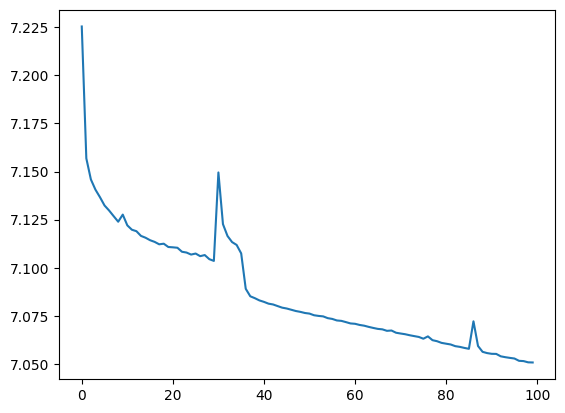

In [17]:
with open("/home/nchibbar/Data/train-history/bart-history.pkl", "rb") as fp:
	history = pickle.load(fp)

plt.plot(history)